# SLCP with NPE

In [1]:
import torch
import torch.nn as nn

from datetime import datetime

from lampe.simulators import IterableSimulator
from lampe.simulators.slcp import SLCP
from lampe.nn import NPE, NLLLoss
from lampe.optim import AdamW, ReduceLROnPlateau
from lampe.train import SummaryWriter, Trainer, NPEPipe
from lampe.mcmc import LRESampler
from lampe.plot import corner

In [2]:
now = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter(log_dir=f'runs/slcp/{now}')

## Training

In [3]:
sim = SLCP().cuda()
train_loader = IterableSimulator(sim, length=256)
valid_loader = IterableSimulator(sim, length=32)

In [4]:
model = NPE(5, 8, embedding=nn.Flatten(-2), architecture='affine', num_transforms=7, num_blocks=3, hidden_features=128)
model.train()
model.cuda()

NPE(
  (flow): MAF(
    (_transform): CompositeTransform(
      (_transforms): ModuleList(
        (0): MaskedAffineAutoregressiveTransform(
          (autoregressive_net): MADE(
            (initial_layer): MaskedLinear(in_features=5, out_features=128, bias=True)
            (context_layer): Linear(in_features=8, out_features=128, bias=True)
            (blocks): ModuleList(
              (0): MaskedFeedforwardBlock(
                (linear): MaskedLinear(in_features=128, out_features=128, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (1): MaskedFeedforwardBlock(
                (linear): MaskedLinear(in_features=128, out_features=128, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (2): MaskedFeedforwardBlock(
                (linear): MaskedLinear(in_features=128, out_features=128, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
    

In [5]:
pipe = NPEPipe(model, criterion=NLLLoss())
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = ReduceLROnPlateau(optimizer, gamma=0.5, patience=7)
trainer = Trainer(pipe, train_loader, valid_loader, optimizer, scheduler, clip=1., writer=writer)

for epoch in trainer(64):
    pass  # something to do in between epochs

Epochs: 100%|██████████████████████████████████████████████████| 64/64 [07:18<00:00,  6.86s/epoch, loss=3.06, lr=0.001]


## Evaluation

In [6]:
_ = model.eval()

### Parameters

In [7]:
parameters = sum(p.numel() for p in model.parameters())
parameters

369222

### Speed

In [8]:
theta, x = next(iter(train_loader))
batches = 2 ** 10

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

with torch.no_grad():
    for _ in range(batches):
        y = model.embedding(x)
        _ = model(theta, y)

end.record()

torch.cuda.synchronize()

seconds = start.elapsed_time(end) * 1e-3

speed = batches / seconds
speed

225.15106143999057

### Corner plot

In [9]:
theta = torch.tensor([0.3517, -0.0883, -1.4778, 1.6406, -1.9085]).cuda()
x = sim(theta)
y = model.embedding(x)

In [10]:
sigma = 0.05 * (sim.upper - sim.lower)

sampler = LRESampler(sim.log_prob, sim.prior, x, batch_size=2 ** 12, sigma=sigma)
thetas = torch.cat([t.cpu() for t in sampler(2 ** 13, burn=2 ** 12, skip=2 ** 4)])

npe_thetas = torch.cat([model.sample(y, (2 ** 12,)).cpu() for _ in range(2 ** 8)])

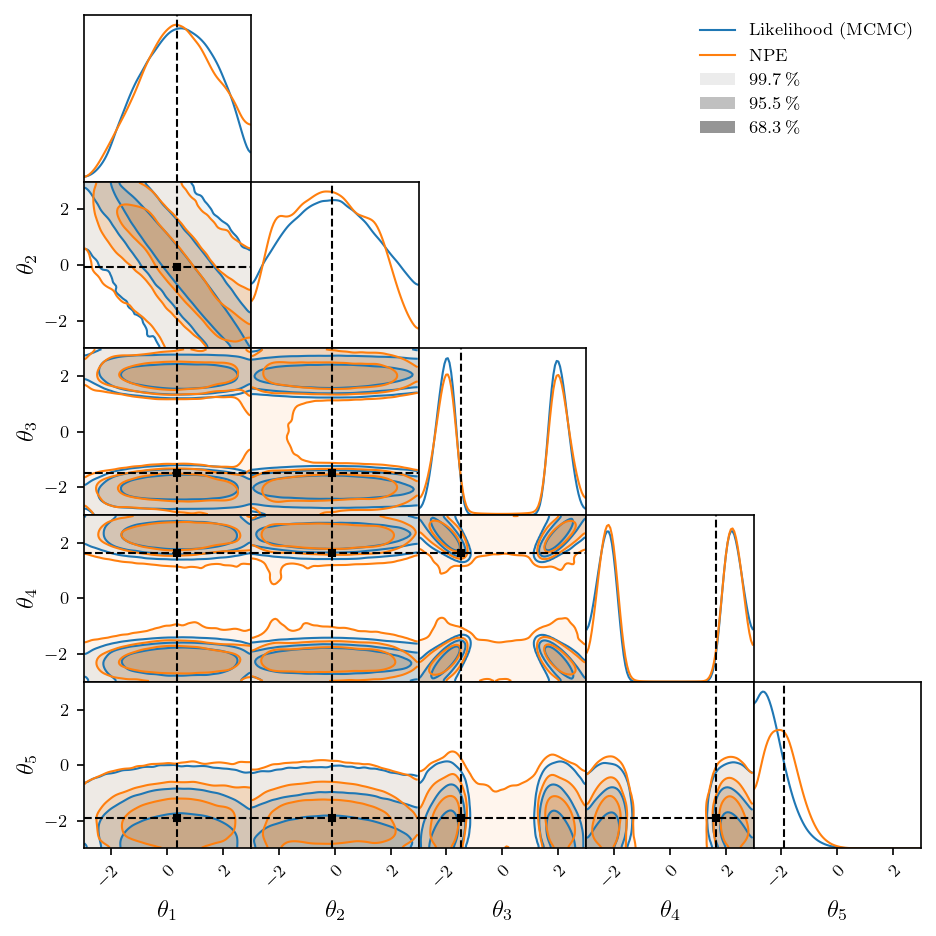

In [11]:
bounds = (sim.lower.cpu().numpy(), sim.upper.cpu().numpy())

fig = corner(
    thetas.numpy(),
    smooth=2.,
    bounds=bounds,
    labels=sim.labels,
    legend='Likelihood (MCMC)',
    markers=[theta.cpu().numpy()],
)

fig = corner(
    npe_thetas.numpy(),
    smooth=2.,
    bounds=bounds,
    legend='NPE',
    figure=fig,
)

## Save

In [12]:
writer.add_hparams(
    hparam_dict={
        'simulator': 'SLCP',
        'embedding': 'Flatten',
        'model': 'NPE',
        'architecture': 'affine',
        'transforms': 7,
        'layers_per_transform': 3,
        'neurons_per_layer': 128,
        'epochs': 64,
        'optimizer': 'AdamW',
        'learning_rate': 1e-3,
        'weight_decay': 1e-3,
        'scheduler': 'ReduceLROnPlateau',
        'gamma': 0.5,
        'patience': 7,
        'gradient_clip': 1.,
    },
    metric_dict={
        'parameters': parameters,
        'batches_per_second': speed,
    },
)